# A single isotope bare sphere


## Imports

Start by importing tripoli-5 python modules.
delos refers to the nuclear data and tripoli5 refers to the simulation.

In [1]:
%load_ext wurlitzer

In [2]:
from tripoli5.core.euclide import Direction, Point
from tripoli5.core.physics import ParticleType
from tripoli5.core.literals import K, MeV
import tripoli5

## User inputs

Define some input parameters useful to define the input data. 

In [3]:
nb_threads = 1  # Number of threads
simulation_mode = "Mono"  # Simulation mode: Mono, OpenMP, ThreadPool
nb_particles_per_batch = 1000  # Number of particles per batch
nb_batches = 100  # Number of batches
tracking_schedule_size = (
    1  # Tracking schedule size : 1 means that history based tracking algorithm is used
)
title = "Sphere-Simple-U235-ROOT-python"

## Geometry

Create an **AGORA** geometry consisting in a single sphere of radius 8.7407 cm.


In [4]:
s1 = tripoli5.agora.Sphere(Point(0.0, 0.0, 0.0), 8.7407)
v1 = tripoli5.agora.Shape(-s1)
c1 = tripoli5.agora.Volume(v1, "U235")
v2 = tripoli5.agora.Shape(s1)
c2 = tripoli5.agora.Volume.outside(v2)
root_universe = tripoli5.agora.Universe([c1, c2])
geo = tripoli5.agora.Geometry(root_universe)

## Plotting the geometry


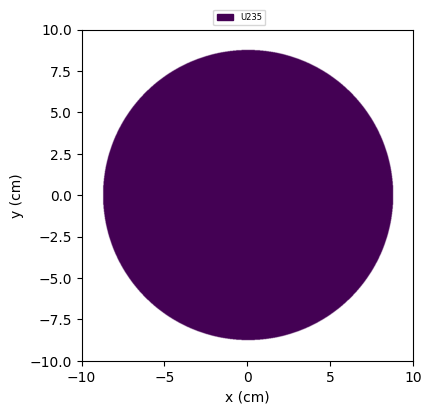

In [5]:
plotter = tripoli5.geoplotter.GeoPlotterPyplot(geo)

frame = tripoli5.geoplotter.Frame.fromMinMax(
    "XY", altitude=0.0, u_min=-10, u_max=10, v_min=-10, v_max=10
)
_ = plotter.plot(frame=frame, resolution=50)

## Nuclear Data and Material Compositions

Print the help of the `MixtureBuilder` which is a helper to build material compositions

In [6]:
help(tripoli5.materials.MixtureBuilder)

Help on class MixtureBuilder in module tripoli5.materials:

class MixtureBuilder(pybind11_builtins.pybind11_object)
 |  A helper to generate mixtures.
 |  
 |  Method resolution order:
 |      MixtureBuilder
 |      pybind11_builtins.pybind11_object
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(...)
 |      __init__(*args, **kwargs)
 |      Overloaded function.
 |      
 |      1. __init__(self: tripoli5.materials.MixtureBuilder) -> None
 |      
 |      2. __init__(self: tripoli5.materials.MixtureBuilder, type_: str) -> None
 |      
 |      Constructor with the builder type choice. Possible types are: 'concentrations', 'mass_fractions', 'atom_fractions'
 |  
 |  add(...)
 |      add(*args, **kwargs)
 |      Overloaded function.
 |      
 |      1. add(self: tripoli5.materials.MixtureBuilder, nuclide_name: str, amount: float) -> tripoli5.materials.MixtureBuilder
 |      
 |      Add a nuclide to the mixture. The amount is defined by the ``type`` that was sel

Load the nuclides' mass data required by the `MixtureBuilder` to compute densities.  
The path to nuclear/mass data catalog file is explicitly specified.  

In [7]:
catalog = tripoli5.delos.Catalog.fromFile(
    f"/opt/tripoli-5/delos/nuclide/endfb8r0_mcnp/endfb8r0_mcnp_v{tripoli5.delos.CATALOG_VERSION}.yaml"
)

[2025-09-03 12:42:57.502] [info] Loading catalog from file: /opt/tripoli-5/delos/nuclide/endfb8r0_mcnp/endfb8r0_mcnp_v2.2.0.yaml


Creates `mixtures`, i.e. material compositions, using the `MixtureBuilder`

In [8]:
fuel = (
    tripoli5.materials.MixtureBuilder("concentrations")
    .withName("U235")
    .withCatalog(catalog)
    .withTemperature(294 * K)
    .add("U235", 4.4994e-02)
    .build()
)
mixtures = [fuel]

[2025-09-03 12:42:57.548] [info] Loading /opt/tripoli-5/delos/nuclide/endfb8r0_mcnp/mass/njoy_ace/v0.2.0/archive/wrapped_mass_data.bin


Convert `Mixtures` into `NeutronMedia` that will be transmitted and used in the simulation.

In [9]:
media = (
    tripoli5.materials.NeutronMediumBuilder()
    .withCatalog(catalog)
    .withMixtures(mixtures)
    .build()
)

[2025-09-03 12:42:57.587] [info] Building U235 at temperatures: TemperatureRange(294 [K], 2.5334957256000003e-08 [MeV], 20.850000000000023 [°C])
[2025-09-03 12:42:57.590] [info] Loading /opt/tripoli-5/delos/nuclide/endfb8r0_mcnp/freegas/njoy_ace/v0.11.0/dir/U235.294.bin
[2025-09-03 12:42:57.666] [info]   Building free gas collisions at temperature 294 [K], 2.5334957256000003e-08 [MeV], 20.850000000000023 [°C]
[2025-09-03 12:42:57.667] [info]   Building reaction MTs = 814, 52, 813, 51, 818, 56, 76, 17, 817, 55, 75, 16, 77, 18, 816, 54, 72, 834, 815, 53, 822, 60, 821, 59, 5, 74, 82, 83, 84, 85, 86, 87, 81, 806, 91, 80, 805, 79, 804, 68, 830, 835, 73, 102, 810, 2, 89, 78, 803, 88, 802, 801, 800, 63, 825, 64, 826, 649, 65, 827, 828, 66, 67, 829, 61, 823, 831, 69, 812, 833, 71, 811, 62, 824, 832, 70, 809, 808, 807, 58, 820, 57, 819


Print some informations to check the number of nuclides, compositions

In [10]:
print(f"Nb NTNuclides =  {media.number_of_nuclides}")
print(f"Nb compositions = {media.number_of_media}")

Nb NTNuclides =  1
Nb compositions = 1


## Sources


Define a source that is:  

- isotropic
- point (0.,0.,0.)
- 2 MeV incident energy

In [11]:
help(tripoli5.source.PointIsotropicSource)

Help on class PointIsotropicSource in module tripoli5.source:

class PointIsotropicSource(ISource)
 |  Method resolution order:
 |      PointIsotropicSource
 |      ISource
 |      pybind11_builtins.pybind11_object
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(...)
 |      __init__(self: tripoli5.source.PointIsotropicSource, type_: tripoli5.core.physics.ParticleType, energy_dist: tripoli5.distributions.energy.IEnergyDistribution, point: tripoli5.core.euclide.Point, norm: float = 1.0, time: float = 0.0) -> None
 |      
 |      Constructor of a Point Isotropic Source of particles from a point located at position (x,y,z)
 |  
 |  ----------------------------------------------------------------------
 |  Static methods inherited from pybind11_builtins.pybind11_object:
 |  
 |  __new__(*args, **kwargs) from pybind11_builtins.pybind11_type
 |      Create and return a new object.  See help(type) for accurate signature.



In [12]:
src = tripoli5.source.PointIsotropicSource(
    ParticleType("Neutron"),
    tripoli5.distributions.energy.MonoKinetic(2.0 * MeV),
    Point(0.0, 0.0, 0.0),  # point source
    1.0,  # norm
    0.0,  # time
)

## Score

Define a flux score over an energy grid of 1000 groups defined with equivalent bins in lethargy. 

In [13]:
score_mgr = tripoli5.score.ScoreManager(title)
flux = tripoli5.score.FluxSpectrumAllVolumes(
    1, 1e-11, 20.0, 1000, "FluxSpectrumAllVolumes"
)
score_mgr.addScore(flux)

Define MT reaction rates for total, capture and fission rates over an energy grid of 1000 groups defined with equivalent bins in lethargy using numpy.

In [14]:
import tripoli5.delos as delos
import numpy as np

mtrates = tripoli5.score.MTReactionRate(
    media,
    [delos.ReactionId(mt_number) for mt_number in [1, 102, 18]],
    1,  # number of volumes
    [e * MeV for e in np.logspace(-11, np.log(20), 1001)],
    "MTRates",
)
score_mgr.addScore(mtrates)
score_mgr.initialize("")

## Simulation setup

Simulation parameters 

In [15]:
help(tripoli5.simulation.SimulationParameters)
simu_params = tripoli5.simulation.SimulationParameters(
    nb_batches,
    nb_particles_per_batch,
    title,
    nb_threads,
    tracking_schedule_size,
    discard=10,
)
print(f"{simu_params.name=}")
print(f"{simu_params.nb_cycles=}")
print(f"{simu_params.nb_events=}")
print(f"{simu_params.nb_threads=}")
print(f"{simu_params.schedule_size=}")
print(f"{simu_params.discard=}")

Help on class SimulationParameters in module tripoli5.simulation:

class SimulationParameters(pybind11_builtins.pybind11_object)
 |  A container that holds the simulation parameters
 |  
 |  Method resolution order:
 |      SimulationParameters
 |      pybind11_builtins.pybind11_object
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(...)
 |      __init__(self: tripoli5.simulation.SimulationParameters, nb_cycles: int = 100, nb_events: int = 100, name: str = '', nb_threads: int = 1, schedule_size: int = 1, random_seed: Optional[int] = None, discard: Optional[int] = None, idconf: Optional[tripoli5.simulation.IdSyncEngineConfig] = None, bundle_size: int = 100) -> None
 |      
 |      Default constructor
 |  
 |  ----------------------------------------------------------------------
 |  Readonly properties defined here:
 |  
 |  bundle_size
 |      Number of simulated particles before tallying
 |  
 |  discard
 |      Number of discarded cycles
 |  
 |  idsync_conf

## Launching the code

Create the simulation object. The following data must be provided:

- source
- geo
- simulation parameters
- media (through `setMedia`)
- scores (through `setUserScores`)

In [16]:
help(tripoli5.simulation.SimulationBuilder)

Help on class SimulationBuilder in module tripoli5.simulation:

class SimulationBuilder(pybind11_builtins.pybind11_object)
 |  A helper to generate simulation.
 |  
 |  Method resolution order:
 |      SimulationBuilder
 |      pybind11_builtins.pybind11_object
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(...)
 |      __init__(*args, **kwargs)
 |      Overloaded function.
 |      
 |      1. __init__(self: tripoli5.simulation.SimulationBuilder) -> None
 |      
 |      2. __init__(self: tripoli5.simulation.SimulationBuilder, simulation_mode: str, parallelism_type: str) -> None
 |      
 |      Constructor with the simulation mode and the parallel type.Possible simulation modes are: 'fixed_source', 'criticality'.
 |      Possible parallelism types are: 'mono', 'openmp'
 |  
 |  build(...)
 |      build(self: tripoli5.simulation.SimulationBuilder) -> tripoli5.simulation.ISimulation
 |      
 |      Build the simulation using provided characteristics
 |  
 |  w

In [17]:
simu = (
    tripoli5.simulation.SimulationBuilder(
        simulation_mode="criticality", parallelism_type="openmp"
    )
    .withSource(src)
    .withGeometry(geo)
    .withMedia("Neutron", media)
    .withParameters(simu_params)
    .withScores(score_mgr)
    .build()
)

Running the simulation 

In [18]:
simu.run()

[2025-09-03 12:42:57.841] [info] *** Beginning of simulation ***
[2025-09-03 12:42:57.843] [info] Cycle: 1 of 100
[2025-09-03 12:42:57.879] [info]   kstep = 1.34100
[2025-09-03 12:42:57.879] [info]   Mean number of collisions: 3.2440
[2025-09-03 12:42:57.879] [info] Cycle: 2 of 100
[2025-09-03 12:42:57.899] [info]   kstep = 1.16700
[2025-09-03 12:42:57.899] [info]   Mean number of collisions: 2.6760
[2025-09-03 12:42:57.899] [info] Cycle: 3 of 100
[2025-09-03 12:42:57.920] [info]   kstep = 1.02200
[2025-09-03 12:42:57.920] [info]   Mean number of collisions: 2.6200
[2025-09-03 12:42:57.920] [info] Cycle: 4 of 100
[2025-09-03 12:42:57.939] [info]   kstep = 0.95800
[2025-09-03 12:42:57.939] [info]   Mean number of collisions: 2.4680
[2025-09-03 12:42:57.939] [info] Cycle: 5 of 100
[2025-09-03 12:42:57.958] [info]   kstep = 0.99500
[2025-09-03 12:42:57.958] [info]   Mean number of collisions: 2.4570
[2025-09-03 12:42:57.958] [info] Cycle: 6 of 100
[2025-09-03 12:42:57.978] [info]   kstep 

## Printing out results into files

### keff results

In [19]:
kstep = simu.getScore(0)
kstep.writeToFile("kstep-u235.log")
with open("kstep-u235.log", "r") as f:
    line = f.readline()
    print(line)

KSTEP statistics : 0.97253	0.00376



In [20]:
flux.writeToFile("flux-spectrum-u235.log")
mtrates.writeToFile("mt-rates-u235.log")

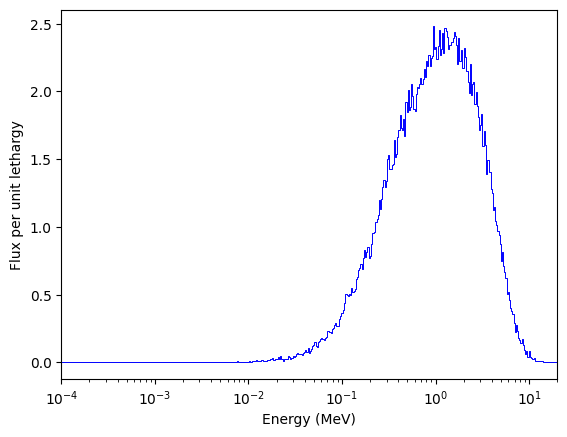

In [21]:
import numpy as np
import matplotlib.pyplot as plt

energies, mean, std = np.loadtxt(
    "flux-spectrum-u235.log", dtype=float, usecols=(2, 3, 4), unpack=True, skiprows=1
)
energies = np.append(energies, 20.0)

mean_per_lethargy_width = [
    m / (np.log(l2) - np.log(l1))
    for m, l1, l2 in zip(mean, energies[:-1], energies[1:])
]
# hack for step-post proper display
mean_per_lethargy_width.append(mean_per_lethargy_width[-1])
plt.plot(
    energies,
    mean_per_lethargy_width,
    linestyle="-",
    linewidth=0.7,
    color="blue",
    drawstyle="steps-post",
    label="Tripoli-5",
)
plt.xlabel("Energy (MeV)")
plt.ylabel("Flux per unit lethargy")
plt.xlim(1e-4, 20)
plt.xscale("log")

In [22]:
import pandas as pd

df = pd.read_csv("mt-rates-u235.log", sep=r"\s+")
df.head()

volume_rank  group_id             E   MT       name  mean  mean_std
0            0         0  1.000000e-11    1    z,total   0.0       0.0
1            0         0  1.000000e-11  102        z,g   0.0       0.0
2            0         0  1.000000e-11   18  z,fission   0.0       0.0
3            0         1  1.032750e-11    1    z,total   0.0       0.0
4            0         1  1.032750e-11  102        z,g   0.0       0.0

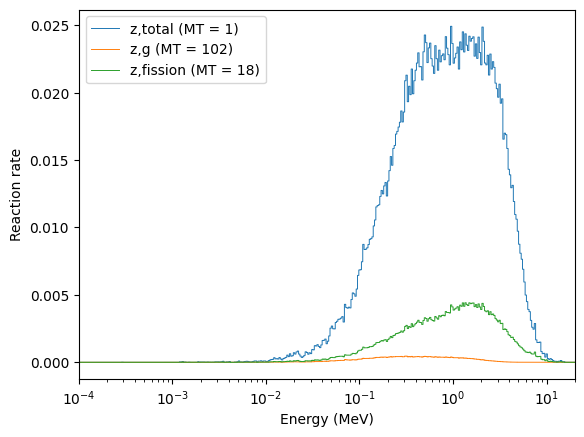

In [23]:
for mt in df.MT.unique():
    df_partial = df[df.MT == mt]
    plt.plot(
        df_partial.E,
        df_partial["mean"],
        linestyle="-",
        linewidth=0.7,
        drawstyle="steps-post",
        label=f"{df_partial['name'].unique()[0]} (MT = {mt})",
    )
plt.xlabel("Energy (MeV)")
plt.ylabel(f"Reaction rate")
plt.xlim(1e-4, 20)
plt.xscale("log")
plt.legend()
plt.show()